# Cloud Pendulum Tutorial

Here is a simple example showing how to use the Cloud Pendulum system. This is a system that allows users to remotely run experiments on physical pendulum hardware. The clients requests a "cell" to run their experiment on, and the server gives access to these cells whenever one is available. There are many types of experiments you can run on this system (e.g. simple pendulum, double pendulum, acrobot, pendubot etc.), each requiring a specific type of hardware in the cell. In this tutorial we will be using the `SimplePendulum` experiment type, which runs on cells that contain a single motor, like the one in the following picture:

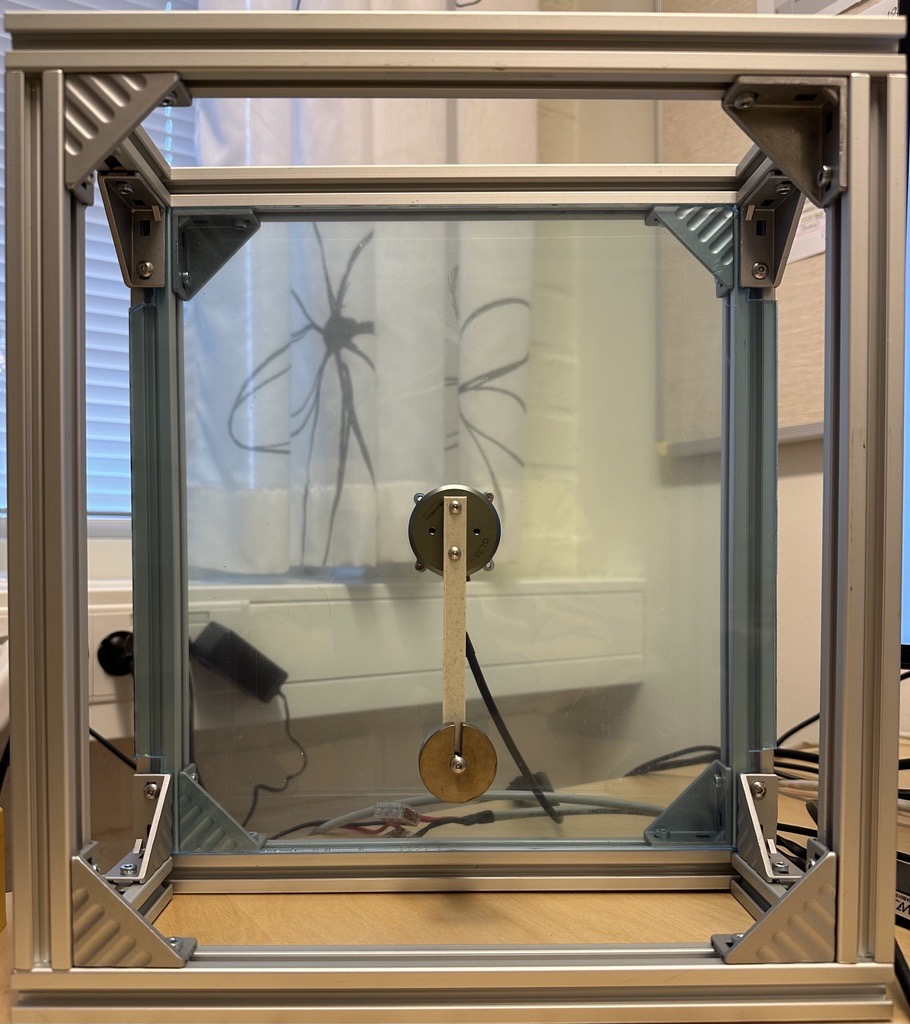

# Pre-requisite

The first step is to create an account on the cloud pendulum JupyterHub: https://cloudpendulum.m2.chalmers.se:1443/hub/signup. Once you sign up, contact one of the administrators to authorize your account. Once we authorize, you will be able to login into the system and write your own code for example, related to modeling, simulation, learning and control. During the authorization, you will also be provided with a user token with which you can do experiments on the real hardware. 

# Setup

To communicate with the server, we use the `cloudpendulum` client package. The documentation for this package can be found here: https://cloudpendulum.m2.chalmers.se/docs/.

In [1]:
from cloudpendulumclient.client import Client

The interface is built around the `Client` class, which handles the connection to the server. To start an experiment, the `start_experiment` method is used to ask the server to reserve a 'cell' for some period of time. We supply a `user_token` to this method which is used by the server to authenticate the user.

In [2]:
user_token = "ENTER YOUR USER TOKEN HERE"

You can find your user token in the 'user_token' file in your home directory.

Let's try starting an experiment:

In [3]:
client = Client()
session_token, livestream_url = client.start_experiment(
    user_token = user_token,
    experiment_type = "SimplePendulum",
    requested_time = 5.0,
    record = True
)
print("Received response from server!")
print("Session token: ", session_token)
print("Livestream url: ", livestream_url)
print("Sleeping...")
import time
time.sleep(3.0)
print("Stopping experiment")
video_url = client.stop_experiment(session_token)
time.sleep(1.0)

# Show video
from misc import download_video
video_path = download_video(video_url)
from IPython.display import Video
Video(video_path)

Waiting on queue...
Received response from server!
Session token:  1922539935019842560
Livestream url:  ['http://cloudpendulum.m2.chalmers.se:5080/live/viewer.jsp?host=cloudpendulum.m2.chalmers.se&stream=camera_141']
Sleeping...
Stopping experiment
Conversion successful: videos.mp4


When running the `start_experiment`, you may have received a response immediately, or it may have taken a while. The reason for this is that the server will wait to send the reply until it has successfully found an appropriate cell available to reserve for the client. If many clients are using the system simultaneously, some may have to wait for their turn.

From the `start_experiment` method, we get a session token and a livestream url. The session token is used by the server to authenticate all subsequent request relating to this experiment session, and the livestream url is used to view a live video feed of the experiment. The `stop_experiment` method is used to stop the experiment, as you would expect. If we had not used the `stop_experiment` method, the experiment would have stopped by itself after 5 seconds.

Since we specified `record = True` when starting the experiment, we get a video url from `stop_experiment` so that we can watch the experiment.

# Controlling the motor

Now that we have reserved a cell from the server, let's do something a little bit more interesting; Let's control the motor! The motors are by default started in impedance control mode with proportional gain Kp and derivative gain Kd set to zero i.e. pure torque control. In this example we use `set_position` to set the position of the motor directly. We could also have used `set_velocity` or `set_torque` to set the velocity and torque of the motor respectively. We can use the `get_position`, `get_velocity` and `get_torque` methods to measure the position, velocity and torque from the motor. 

Waiting on queue...
Received response from server!
Session token:  1320401701883292160
Livestream url:  ['http://cloudpendulum.m2.chalmers.se:5080/live/viewer.jsp?host=cloudpendulum.m2.chalmers.se&stream=camera_141']
Running the control loop
Finished


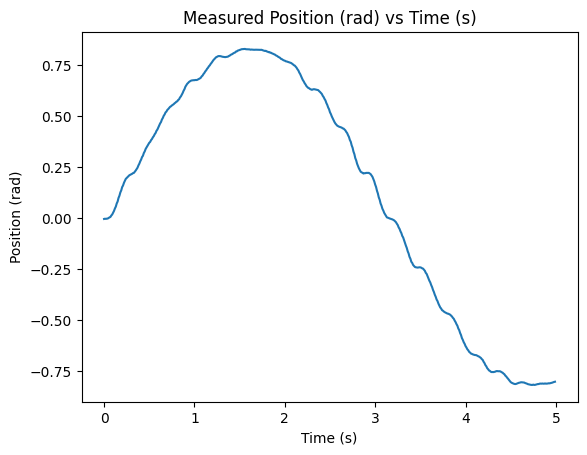

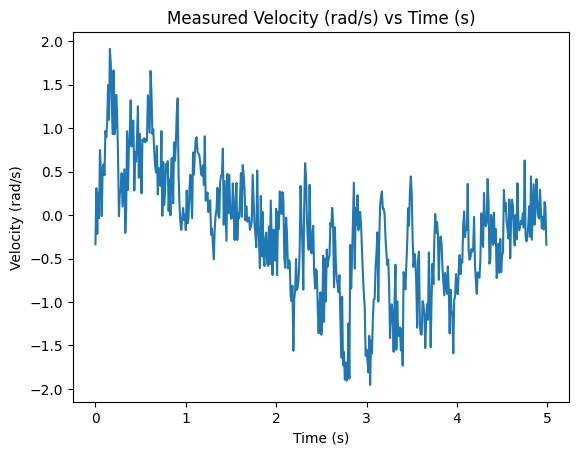

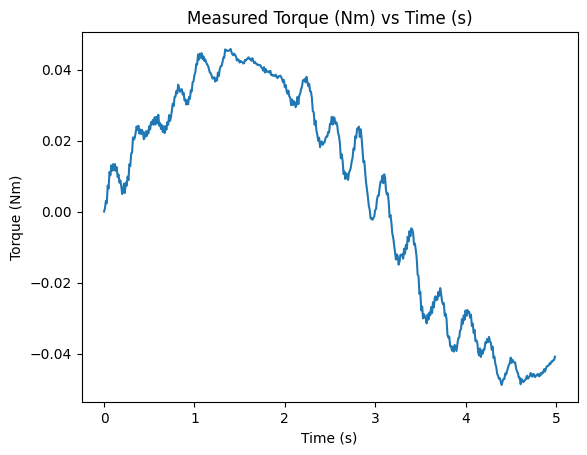

Conversion successful: videos/camera_14120250712-012931-AM.mp4


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

Tf = 5.0
client = Client()
session_token, livestream_url = client.start_experiment(
    user_token = user_token,
    experiment_type = "SimplePendulum",
    requested_time = Tf,
    record = True
)
print("Received response from server!")
print("Session token: ", session_token)
print("Livestream url: ", livestream_url)

# Set Kp, Kd for position control
kp = 0.25
kd = 0.0015
client.set_impedance_controller_params([kp], [kd], session_token)

dt = 0.01
meas_dt = 0.0
meas_time = 0.0

n = int(Tf / dt)

meas_time_vec = np.zeros(n)
meas_pos = np.zeros(n)
meas_vel = np.zeros(n)
meas_tau = np.zeros(n)
i = 0

print("Running the control loop")
while meas_time < Tf and i < n:
    start_loop = time.time()
    meas_time += meas_dt

    ## Do your stuff here - START

    measured_position = client.get_position(session_token) # Measure position
    measured_velocity = client.get_velocity(session_token) # Measure velocity
    measured_torque = client.get_torque(session_token) # Measure torque

    # Send position command
    client.set_position(math.sin(meas_time), session_token)

    # Collect data for plotting
    meas_time_vec[i] = meas_time
    meas_pos[i] = measured_position
    meas_vel[i] = measured_velocity    
    meas_tau[i] = measured_torque
        
    ## Do your stuff here - END
    i = i + 1
    exec_time = time.time() - start_loop

    while time.time() - start_loop < dt:
        pass
    meas_dt = time.time() - start_loop

print("Finished")

video_url = client.stop_experiment(session_token)
time.sleep(1.0)

# Show plots
plt.figure
plt.plot(meas_time_vec, meas_pos)
plt.xlabel("Time (s)") 
plt.ylabel("Position (rad)")
plt.title("Measured Position (rad) vs Time (s)")
plt.show()

# Measured Velocity
plt.figure
plt.plot(meas_time_vec, meas_vel)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (rad/s)")
plt.title("Measured Velocity (rad/s) vs Time (s)")
plt.show()

# Measured Torque
plt.figure
plt.plot(meas_time_vec, meas_tau)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Measured Torque (Nm) vs Time (s)")
plt.show()

# Show video
from misc import download_video
video_path = download_video(video_url)
from IPython.display import Video
Video(video_path)



# Note 
The position tracking is not perfect. By selecting better Kp and Kd values this can be improved.

In [ ]:
client.get_user_info(user_token) # Monitor the status of your user token